In [1]:
import pandas as pd
import numpy as np
import torch
from data_factory.DataLoader import DataLoader
from utils.config import load_config

# models
from models.LSTM_autoencoder.RecurrentAutoencoder import RecurrentAutoencoder

# evaluation file
from utils.evaluation import label_evaluation

import matplotlib.pyplot as plt

import sys

sys.path.append('/media/cyprien/Data/Documents/Github/pytorch-forecasting')



In [2]:
dl = DataLoader(use_previous_files=False, config_file="../config/config.yml")

INFO:data_factory.DataLoader:../data/train.csv loaded. shape (2476315, 4)
INFO:data_factory.DataLoader:../data/test.csv loaded. shape (2345211, 3)
DEBUG:data_factory.preprocessing:Fill grp 02e99bd4f6cfb33f. shape: (128562, 6)
DEBUG:data_factory.preprocessing:Fill grp 02e99bd4f6cfb33f Done. shape: (131795, 5)
DEBUG:data_factory.preprocessing:Fill grp 046ec29ddf80d62e. shape: (8784, 6)
DEBUG:data_factory.preprocessing:Fill grp 046ec29ddf80d62e Done. shape: (43916, 5)
DEBUG:data_factory.preprocessing:Fill grp 07927a9a18fa19ae. shape: (10960, 6)
DEBUG:data_factory.preprocessing:Fill grp 07927a9a18fa19ae Done. shape: (61471, 5)
DEBUG:data_factory.preprocessing:Fill grp 09513ae3e75778a3. shape: (128971, 6)
DEBUG:data_factory.preprocessing:Fill grp 09513ae3e75778a3 Done. shape: (131785, 5)
DEBUG:data_factory.preprocessing:Fill grp 18fbb1d5a5dc099d. shape: (129128, 6)
DEBUG:data_factory.preprocessing:Fill grp 18fbb1d5a5dc099d Done. shape: (131795, 5)
DEBUG:data_factory.preprocessing:Fill grp 1

In [3]:
result_file = '../predict.csv'
truth_file = '../ground_truth.hdf'

## Feature Engineering

In [4]:
dl.train['timestamp_1'] = (dl.train.timestamp / 60).astype(int)

In [11]:
normal_train = dl.train[dl.train.label == 0].drop(labels='label', axis=1)
normal_val = dl.val[dl.val.label == 0].drop(labels='label', axis=1)
normal_train.shape, normal_val.shape

((2604161, 34), (131019, 33))

In [12]:
anomaly_train = dl.train[dl.train.label == 1].drop(labels='label', axis=1)
anomaly_val = dl.val[dl.val.label == 1].drop(labels='label', axis=1)
anomaly_train.shape, anomaly_val.shape

((45081, 34), (8419, 33))

In [13]:
from data_factory.preprocessing import *

normal_train = fill_missing_dates(normal_train, date_col='datetime', timestamp_col='timestamp',
                                  grp_col='kpi_id').copy()
normal_train.authentic = normal_train.authentic.astype(str)

DEBUG:data_factory.preprocessing:Fill grp 02e99bd4f6cfb33f. shape: (114853, 34)
DEBUG:data_factory.preprocessing:Fill grp 02e99bd4f6cfb33f Done. shape: (125205, 33)
DEBUG:data_factory.preprocessing:Fill grp 046ec29ddf80d62e. shape: (41640, 34)
DEBUG:data_factory.preprocessing:Fill grp 046ec29ddf80d62e Done. shape: (41720, 33)
DEBUG:data_factory.preprocessing:Fill grp 07927a9a18fa19ae. shape: (58267, 34)
DEBUG:data_factory.preprocessing:Fill grp 07927a9a18fa19ae Done. shape: (58397, 33)
DEBUG:data_factory.preprocessing:Fill grp 09513ae3e75778a3. shape: (124958, 34)
DEBUG:data_factory.preprocessing:Fill grp 09513ae3e75778a3 Done. shape: (125196, 33)
DEBUG:data_factory.preprocessing:Fill grp 18fbb1d5a5dc099d. shape: (117361, 34)
DEBUG:data_factory.preprocessing:Fill grp 18fbb1d5a5dc099d Done. shape: (125205, 33)
DEBUG:data_factory.preprocessing:Fill grp 1c35dbf57f55f5e4. shape: (118102, 34)
DEBUG:data_factory.preprocessing:Fill grp 1c35dbf57f55f5e4 Done. shape: (125006, 33)
DEBUG:data_fac

In [14]:
normal_train['timestamp_1'] = (normal_train.timestamp / 60).astype(int)
max_prediction_length = 1
max_encoder_length = 24000 - 1


In [17]:
from pytorch_forecasting import TimeSeriesDataSet, GroupNormalizer

kpi_id_ref = normal_train.kpi_id.unique()[0]

X_cols = ['value_scaled', 'kpi_id', 'timestamp_1', 'authentic']
normal_train = normal_train.reset_index(drop=True)

is_training = normal_train.groupby('kpi_id').apply(
    lambda x: x.timestamp_1 < (x.timestamp_1.max() - (max_encoder_length + max_prediction_length))).reset_index(
    drop=True)

training = TimeSeriesDataSet(normal_train.loc[is_training & (normal_train.kpi_id == kpi_id_ref), X_cols],
                             time_idx='timestamp_1', target='value_scaled',
                             group_ids=['kpi_id'],
                             allow_missing_timesteps=False,
                             static_categoricals=['kpi_id', 'authentic'],
                             time_varying_unknown_reals=['value_scaled'],
                             # time_varying_known_reals=['timestamp_1'],
                             # min_encoder_length=345,
                             max_encoder_length=max_encoder_length,
                             max_prediction_length=max_prediction_length,
                             scalers={col: None for col in ['timestamp_1', 'kpi_id']},
                             target_normalizer=None,
                             # target_normalizer=GroupNormalizer(
                             #     groups=['kpi_id'], transformation="softplus"
                             # ),
                             add_relative_time_idx=False,
                             add_target_scales=False,
                             add_encoder_length=False,
                             )

validation = TimeSeriesDataSet.from_dataset(training, normal_train[(normal_train.kpi_id == kpi_id_ref)],
                                            stop_randomization=True, predict=True)

In [18]:
batch_size = 64

training_dl = training.to_dataloader(train=True, batch_size=batch_size)
validation_dl = validation.to_dataloader(train=False, batch_size=batch_size)


## Model

In [19]:
from models.autoencoder import AE

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using", device)
n_features = 1
n_dim = 256

using cuda


In [21]:
torch.concat([
    next(iter(training_dl))[0]['encoder_cont'].squeeze(2).moveaxis(1, 0),
    next(iter(training_dl))[0]['decoder_target'].moveaxis(1, 0)
]).moveaxis(1, 0).shape

torch.Size([64, 24000])

In [23]:

print(torch.concat([
    next(iter(training_dl))[0]['encoder_cat'].squeeze(2).moveaxis(1, 0),
    next(iter(training_dl))[0]['decoder_cat'].moveaxis(1, 0)
]).moveaxis(1, 0).shape)

# next(iter(training_dl))[0]['encoder_cat'].reshape(-1, 2)[:, 0].min()
torch.concat([
    next(iter(training_dl))[0]['encoder_cat'].squeeze(2).moveaxis(1, 0),
    next(iter(training_dl))[0]['decoder_cat'].moveaxis(1, 0)
]).moveaxis(1, 0)[:, :, 1].sum()


torch.Size([64, 24000, 2])


tensor(1270014)

In [26]:
from torch import nn
from tqdm import tqdm
import copy

model = AE(input_shape=max_encoder_length + max_prediction_length, n_dim=n_dim)
model = model.to(device)


def train_model(model, train_dataset, val_dataset, n_epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.L1Loss(reduction='sum').to(device)
    history = dict(train=[], val=[])
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1000000.0

    for epoch in range(1, n_epochs + 1):

        ## Train
        model = model.train()
        train_losses = []
        progress_bar = tqdm(training_dl)
        for X, (y, _) in progress_bar:
            seq_true = torch.concat([
                next(iter(training_dl))[0]['encoder_cont'].squeeze(2).moveaxis(1, 0),
                next(iter(training_dl))[0]['decoder_target'].moveaxis(1, 0)
            ]).moveaxis(1, 0).to(torch.float).to(device)
            filter = torch.concat([
                next(iter(training_dl))[0]['encoder_cat'].squeeze(2).moveaxis(1, 0),
                next(iter(training_dl))[0]['decoder_cat'].moveaxis(1, 0)
            ]).moveaxis(1, 0).to(device).to(torch.bool)[:, :, 1]
            optimizer.zero_grad()
            seq_pred = model(seq_true)
            loss = criterion(seq_pred[filter], seq_true[filter])
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
            progress_bar.set_description(desc=f'loss: {round(loss.item())}')
        val_losses = []

        ## Eval
        best_model_wts, model, train_loss, val_loss = eval(best_loss, best_model_wts, criterion, history, model,
                                                           train_losses, val_losses)
        print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')
    model.load_state_dict(best_model_wts)
    return model.eval(), history


def eval(best_loss, best_model_wts, criterion, history, model, train_losses, val_losses):
    model = model.eval()
    with torch.no_grad():
        progress_bar = tqdm(validation_dl, desc='validation')
        for X, (y, _) in progress_bar:
            seq_true = torch.concat([
                next(iter(training_dl))[0]['encoder_cont'].squeeze(2).moveaxis(1, 0),
                next(iter(training_dl))[0]['decoder_target'].moveaxis(1, 0)
            ]).moveaxis(1, 0).to(torch.float).to(device)
            filter = torch.concat([
                next(iter(training_dl))[0]['encoder_cat'].squeeze(2).moveaxis(1, 0),
                next(iter(training_dl))[0]['decoder_cat'].moveaxis(1, 0)
            ]).moveaxis(1, 0).to(device).to(torch.bool)[:, :, 1]
            seq_pred = model(seq_true)
            loss = criterion(seq_pred, seq_true)
            val_losses.append(loss.item())
    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)
    history['train'].append(train_loss)
    history['val'].append(val_loss)
    if val_loss < best_loss:
        best_loss = val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
    return best_model_wts, model, train_loss, val_loss

In [28]:
model, history = train_model(
    model,
    training_dl,
    validation_dl,
    n_epochs=100
)

validation: 100%|██████████| 1/1 [00:00<00:00,  5.26it/s]


Epoch 1: train loss 379294.0861059287 val loss 404376.3125


validation: 100%|██████████| 1/1 [00:00<00:00,  5.57it/s]


Epoch 2: train loss 324661.70232172473 val loss 363464.84375


validation: 100%|██████████| 1/1 [00:00<00:00,  5.59it/s]


Epoch 3: train loss 304118.7423559287 val loss 341957.3125


validation: 100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


Epoch 4: train loss 292343.37181281095 val loss 336191.875


validation: 100%|██████████| 1/1 [00:00<00:00,  5.69it/s]


Epoch 5: train loss 282632.57736059284 val loss 321436.3125


validation: 100%|██████████| 1/1 [00:00<00:00,  5.13it/s]


Epoch 6: train loss 276226.565441024 val loss 315550.15625


validation: 100%|██████████| 1/1 [00:00<00:00,  5.68it/s]


Epoch 7: train loss 270986.2669724295 val loss 315817.8125


validation: 100%|██████████| 1/1 [00:00<00:00,  5.67it/s]


Epoch 8: train loss 267435.6895988806 val loss 307408.9375


validation: 100%|██████████| 1/1 [00:00<00:00,  5.73it/s]


Epoch 9: train loss 264309.3577036692 val loss 309960.5


validation: 100%|██████████| 1/1 [00:00<00:00,  5.73it/s]


Epoch 10: train loss 261574.07080483003 val loss 308021.6875


validation: 100%|██████████| 1/1 [00:00<00:00,  5.70it/s]


Epoch 11: train loss 259874.98502280266 val loss 303790.5625


validation: 100%|██████████| 1/1 [00:00<00:00,  5.20it/s]


Epoch 12: train loss 257875.9993392413 val loss 299448.4375


validation: 100%|██████████| 1/1 [00:00<00:00,  5.53it/s]


Epoch 13: train loss 257028.16568200663 val loss 294927.625


validation: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


Epoch 14: train loss 255883.42806799337 val loss 297223.4375


validation: 100%|██████████| 1/1 [00:00<00:00,  5.46it/s]


Epoch 15: train loss 254481.9351808665 val loss 302959.375


validation: 100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


Epoch 16: train loss 253676.15715692373 val loss 290346.40625


validation: 100%|██████████| 1/1 [00:00<00:00,  5.62it/s]


Epoch 17: train loss 253207.06834317994 val loss 297282.625


validation: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


Epoch 18: train loss 252597.90662572553 val loss 291567.125


validation: 100%|██████████| 1/1 [00:00<00:00,  5.53it/s]


Epoch 19: train loss 251269.32947242953 val loss 295726.21875


validation: 100%|██████████| 1/1 [00:00<00:00,  4.55it/s]


Epoch 20: train loss 250954.72069340796 val loss 297052.125


validation: 100%|██████████| 1/1 [00:00<00:00,  5.35it/s]


Epoch 21: train loss 250798.65086028192 val loss 296816.625


validation: 100%|██████████| 1/1 [00:00<00:00,  5.34it/s]


Epoch 22: train loss 250079.47886867746 val loss 296153.625


validation: 100%|██████████| 1/1 [00:00<00:00,  5.23it/s]


Epoch 23: train loss 249792.13839655888 val loss 295795.5


validation: 100%|██████████| 1/1 [00:00<00:00,  5.35it/s]


Epoch 24: train loss 248972.95347481343 val loss 292103.3125


validation: 100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


Epoch 25: train loss 248561.7135675788 val loss 289548.3125


validation: 100%|██████████| 1/1 [00:00<00:00,  5.58it/s]


Epoch 26: train loss 248280.81639977198 val loss 290528.21875


validation: 100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


Epoch 27: train loss 248067.48871527778 val loss 285312.875


validation: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


Epoch 28: train loss 247524.48543739636 val loss 288062.125


validation: 100%|██████████| 1/1 [00:00<00:00,  5.64it/s]


Epoch 29: train loss 247492.29962168325 val loss 289832.3125


validation: 100%|██████████| 1/1 [00:00<00:00,  5.43it/s]


Epoch 30: train loss 247539.17923403814 val loss 284730.75


validation: 100%|██████████| 1/1 [00:00<00:00,  5.53it/s]


Epoch 31: train loss 247001.237056903 val loss 286810.625


validation: 100%|██████████| 1/1 [00:00<00:00,  5.39it/s]


Epoch 32: train loss 246581.9009768864 val loss 285104.9375


validation: 100%|██████████| 1/1 [00:00<00:00,  5.59it/s]


Epoch 33: train loss 246885.16761245855 val loss 290255.90625


validation: 100%|██████████| 1/1 [00:00<00:00,  5.51it/s]


Epoch 34: train loss 246552.1205301617 val loss 290275.0625


validation: 100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


Epoch 35: train loss 246023.89500414595 val loss 290505.1875


validation: 100%|██████████| 1/1 [00:00<00:00,  5.67it/s]


Epoch 36: train loss 245970.02626191956 val loss 286455.625


validation: 100%|██████████| 1/1 [00:00<00:00,  5.76it/s]


Epoch 37: train loss 245583.57676461444 val loss 284603.5625


validation: 100%|██████████| 1/1 [00:00<00:00,  5.76it/s]


Epoch 38: train loss 245681.98784722222 val loss 286111.5625


validation: 100%|██████████| 1/1 [00:00<00:00,  5.34it/s]


Epoch 39: train loss 244879.32804726367 val loss 283905.125


validation: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


Epoch 40: train loss 245367.00940609453 val loss 283183.25


validation: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


Epoch 41: train loss 244451.5342039801 val loss 285031.15625


validation: 100%|██████████| 1/1 [00:00<00:00,  5.50it/s]


Epoch 42: train loss 244541.6870335821 val loss 283790.75


validation: 100%|██████████| 1/1 [00:00<00:00,  5.77it/s]


Epoch 43: train loss 244449.08412365257 val loss 286232.75


validation: 100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


Epoch 44: train loss 244201.04092817163 val loss 283135.625


validation: 100%|██████████| 1/1 [00:00<00:00,  5.82it/s]


Epoch 45: train loss 243873.88002694858 val loss 284924.1875


validation: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


Epoch 46: train loss 243879.4680633292 val loss 282917.75


validation: 100%|██████████| 1/1 [00:00<00:00,  5.32it/s]


Epoch 47: train loss 244053.65928171642 val loss 284535.4375


validation: 100%|██████████| 1/1 [00:00<00:00,  5.34it/s]


Epoch 48: train loss 243866.5880622927 val loss 290327.4375


validation: 100%|██████████| 1/1 [00:00<00:00,  5.70it/s]


Epoch 49: train loss 243674.5207296849 val loss 285262.6875


validation: 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Epoch 50: train loss 243580.725590796 val loss 281137.3125


validation: 100%|██████████| 1/1 [00:00<00:00,  5.34it/s]


Epoch 51: train loss 243573.05721393035 val loss 279434.8125


validation: 100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


Epoch 52: train loss 243507.93475331675 val loss 283686.0625


validation: 100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


Epoch 53: train loss 242948.17089033997 val loss 283695.0


validation: 100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


Epoch 54: train loss 243497.45689521145 val loss 283630.3125


validation: 100%|██████████| 1/1 [00:00<00:00,  5.17it/s]


Epoch 55: train loss 243062.79340277778 val loss 286652.875


validation: 100%|██████████| 1/1 [00:00<00:00,  5.50it/s]


Epoch 56: train loss 243061.18759069237 val loss 286023.1875


validation: 100%|██████████| 1/1 [00:00<00:00,  4.39it/s]


Epoch 57: train loss 243229.80924803068 val loss 282990.75


validation: 100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


Epoch 58: train loss 242928.77157182837 val loss 286649.625


validation: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


Epoch 59: train loss 242807.8959240257 val loss 280051.96875


validation: 100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


Epoch 60: train loss 242429.87698227612 val loss 279484.75


validation: 100%|██████████| 1/1 [00:00<00:00,  4.47it/s]


Epoch 61: train loss 242188.2969268242 val loss 282869.125


validation: 100%|██████████| 1/1 [00:00<00:00,  5.64it/s]


Epoch 62: train loss 242355.5476523632 val loss 279453.5625


validation: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


Epoch 63: train loss 242319.84027777778 val loss 285136.375


validation: 100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


Epoch 64: train loss 242108.7111318408 val loss 279366.625


validation: 100%|██████████| 1/1 [00:00<00:00,  5.48it/s]


Epoch 65: train loss 242248.88292910447 val loss 287294.21875


validation: 100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


Epoch 66: train loss 242157.92795138888 val loss 281837.5


validation: 100%|██████████| 1/1 [00:00<00:00,  5.77it/s]


Epoch 67: train loss 241924.99573745855 val loss 279829.0625


validation: 100%|██████████| 1/1 [00:00<00:00,  5.37it/s]


Epoch 68: train loss 242393.58154539802 val loss 283385.6875


validation: 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


Epoch 69: train loss 241614.91871372305 val loss 282299.25


validation: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


Epoch 70: train loss 241884.53687292704 val loss 279366.5625


validation: 100%|██████████| 1/1 [00:00<00:00,  5.03it/s]


Epoch 71: train loss 241818.4827425373 val loss 283367.625


validation: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


Epoch 72: train loss 241503.16636867746 val loss 278506.4375


validation: 100%|██████████| 1/1 [00:00<00:00,  5.69it/s]


Epoch 73: train loss 241289.68417029435 val loss 286101.625


validation: 100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


Epoch 74: train loss 241885.70364324213 val loss 275308.78125


validation: 100%|██████████| 1/1 [00:00<00:00,  5.35it/s]


Epoch 75: train loss 241324.84908789388 val loss 288711.59375


validation: 100%|██████████| 1/1 [00:00<00:00,  5.30it/s]


Epoch 76: train loss 241215.9173792496 val loss 285031.8125


validation: 100%|██████████| 1/1 [00:00<00:00,  5.75it/s]


Epoch 77: train loss 241235.52911225124 val loss 283547.90625


validation: 100%|██████████| 1/1 [00:00<00:00,  4.57it/s]


Epoch 78: train loss 241155.04529436154 val loss 282347.1875


validation: 100%|██████████| 1/1 [00:00<00:00,  5.27it/s]


Epoch 79: train loss 241218.9666770315 val loss 280469.0625


validation: 100%|██████████| 1/1 [00:00<00:00,  5.20it/s]


Epoch 80: train loss 240959.92479011195 val loss 280072.3125


validation: 100%|██████████| 1/1 [00:00<00:00,  5.30it/s]


Epoch 81: train loss 241235.86383188225 val loss 282965.71875


validation: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


Epoch 82: train loss 241274.78539593698 val loss 279346.34375


validation: 100%|██████████| 1/1 [00:00<00:00,  5.58it/s]


Epoch 83: train loss 240787.1492148632 val loss 276916.8125


validation: 100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


Epoch 84: train loss 241203.42626710198 val loss 281033.125


validation: 100%|██████████| 1/1 [00:00<00:00,  5.85it/s]


Epoch 85: train loss 240876.9202684494 val loss 280916.71875


validation: 100%|██████████| 1/1 [00:00<00:00,  5.17it/s]


Epoch 86: train loss 240757.6773942786 val loss 282362.5


validation: 100%|██████████| 1/1 [00:00<00:00,  5.14it/s]


Epoch 87: train loss 240892.92894900497 val loss 278631.0625


validation: 100%|██████████| 1/1 [00:00<00:00,  4.33it/s]


Epoch 88: train loss 240608.32645366914 val loss 282159.6875


validation: 100%|██████████| 1/1 [00:00<00:00,  5.31it/s]


Epoch 89: train loss 240722.7741241708 val loss 286751.25


validation: 100%|██████████| 1/1 [00:00<00:00,  5.26it/s]


Epoch 90: train loss 240525.64031405473 val loss 278791.6875


validation: 100%|██████████| 1/1 [00:00<00:00,  5.47it/s]


Epoch 91: train loss 240368.58935789802 val loss 281833.5625


validation: 100%|██████████| 1/1 [00:00<00:00,  5.24it/s]


Epoch 92: train loss 240290.75967817163 val loss 281463.75


validation: 100%|██████████| 1/1 [00:00<00:00,  5.42it/s]


Epoch 93: train loss 240153.00926357793 val loss 277576.8125


validation: 100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


Epoch 94: train loss 240448.30707141376 val loss 283869.6875


validation: 100%|██████████| 1/1 [00:00<00:00,  5.20it/s]


Epoch 95: train loss 240390.07789179104 val loss 279599.5625


validation: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


Epoch 96: train loss 240302.2859919154 val loss 282070.875


validation: 100%|██████████| 1/1 [00:00<00:00,  5.29it/s]


Epoch 97: train loss 240237.58091055142 val loss 281577.59375


validation: 100%|██████████| 1/1 [00:00<00:00,  5.64it/s]


Epoch 98: train loss 239792.81816179518 val loss 281647.03125


validation: 100%|██████████| 1/1 [00:00<00:00,  5.17it/s]


Epoch 99: train loss 239951.2209913972 val loss 276746.9375


validation: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s]

Epoch 100: train loss 240257.42701855308 val loss 285416.75


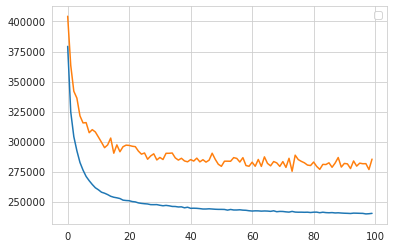

In [39]:
plt.plot(pd.DataFrame(history))
plt.show()

In [30]:
X = torch.concat([
    next(iter(validation_dl))[0]['encoder_cont'].squeeze(2).moveaxis(1, 0),
    next(iter(validation_dl))[0]['decoder_target'].moveaxis(1, 0)
]).moveaxis(1, 0).to(device).to(torch.float)
X_true = X.cpu().numpy()[0]
X_pred = model(X).cpu().detach().numpy()[0]


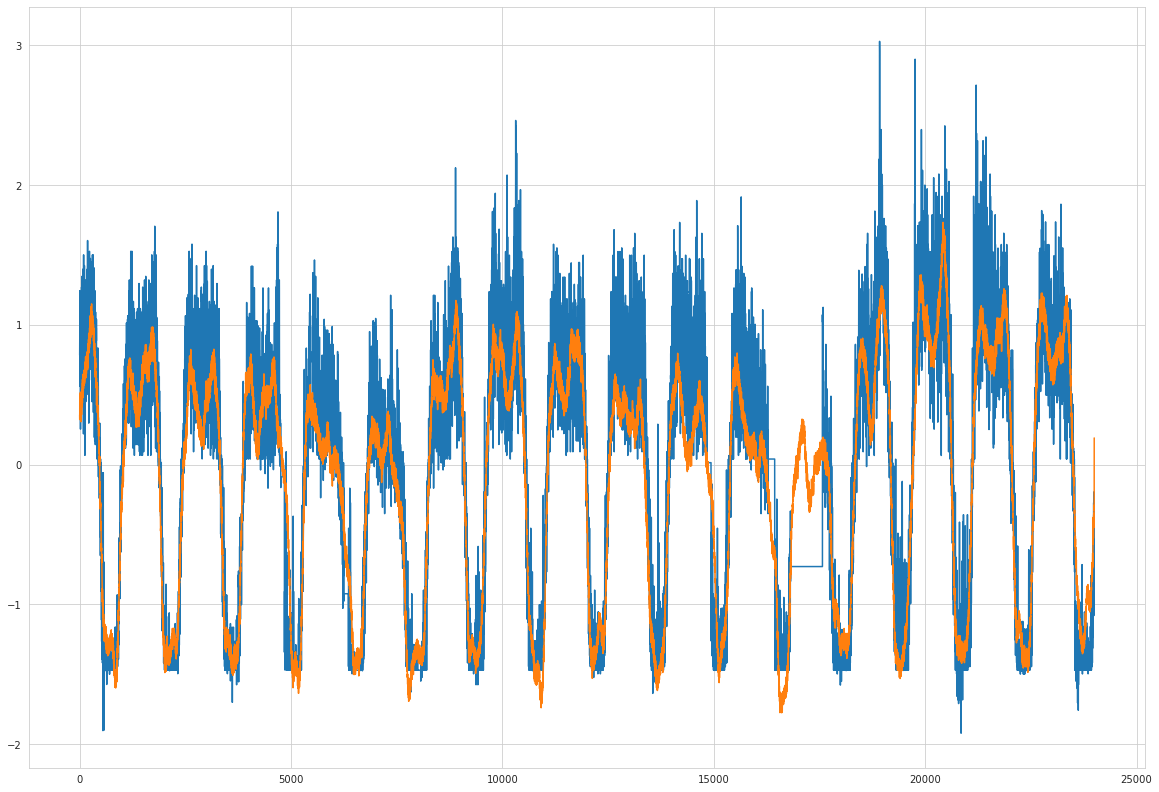

In [31]:
figure = plt.figure(figsize=(20, 14))

plt.plot(X_true, figure=figure)
plt.plot(X_pred, figure=figure)
plt.show()

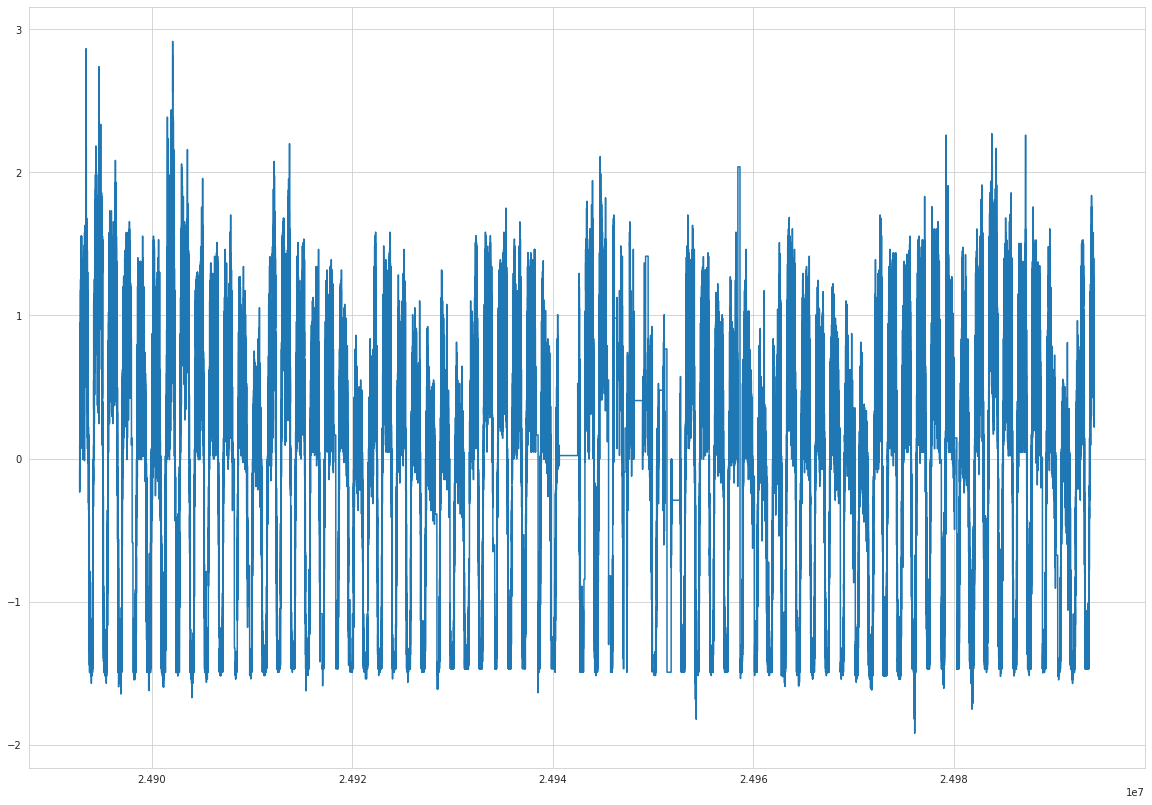

In [32]:
df = normal_train.loc[is_training & (normal_train.kpi_id == kpi_id_ref), X_cols]

figure = plt.figure(figsize=(20, 14))

plt.plot(df.timestamp_1, df.value_scaled, figure=figure)
# plt.plot(X_pred, figure=figure)
plt.show()


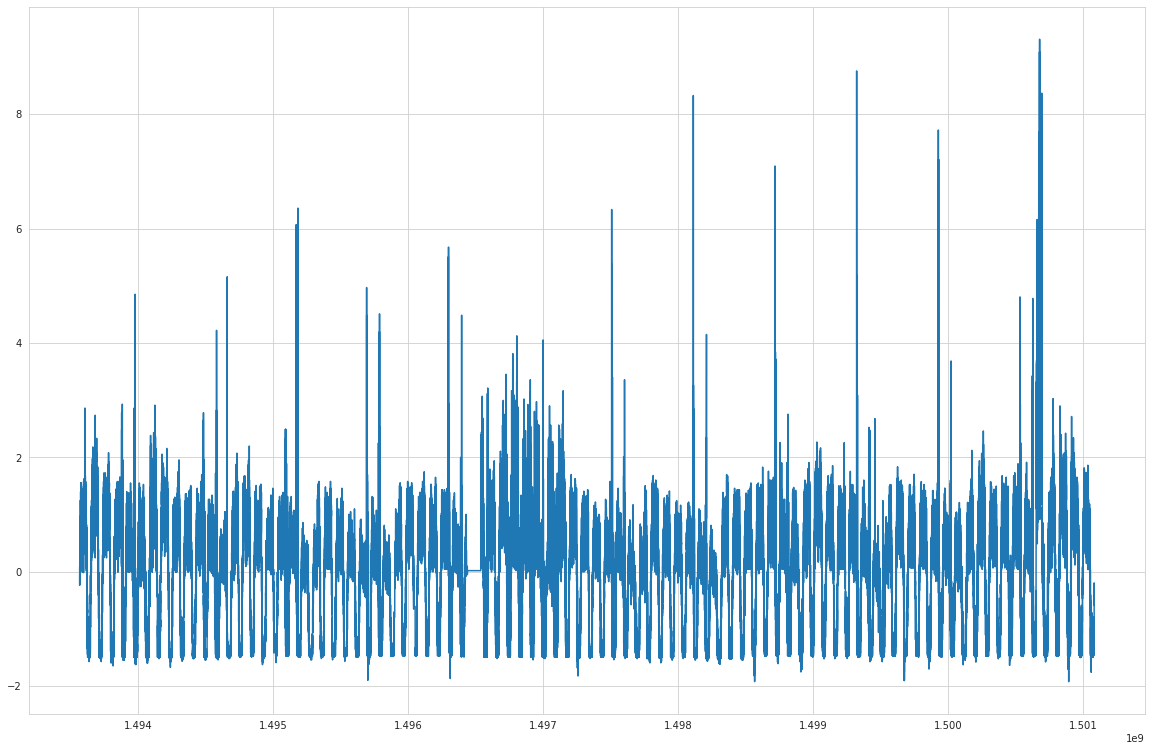

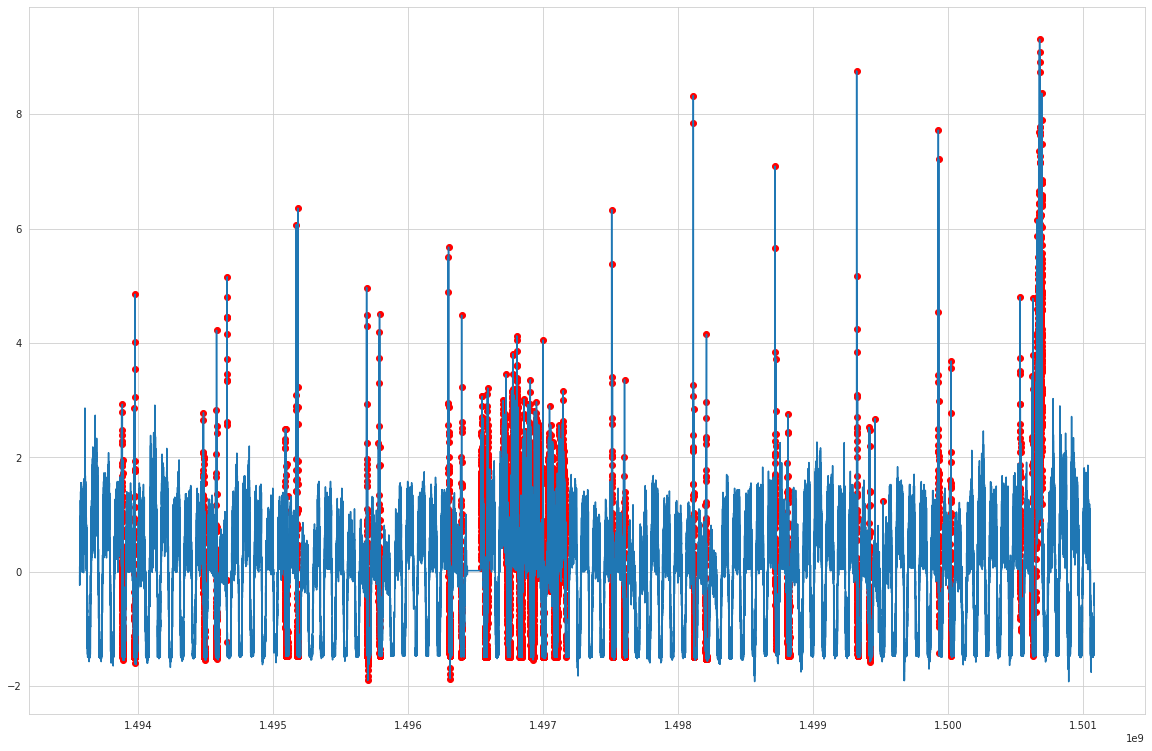

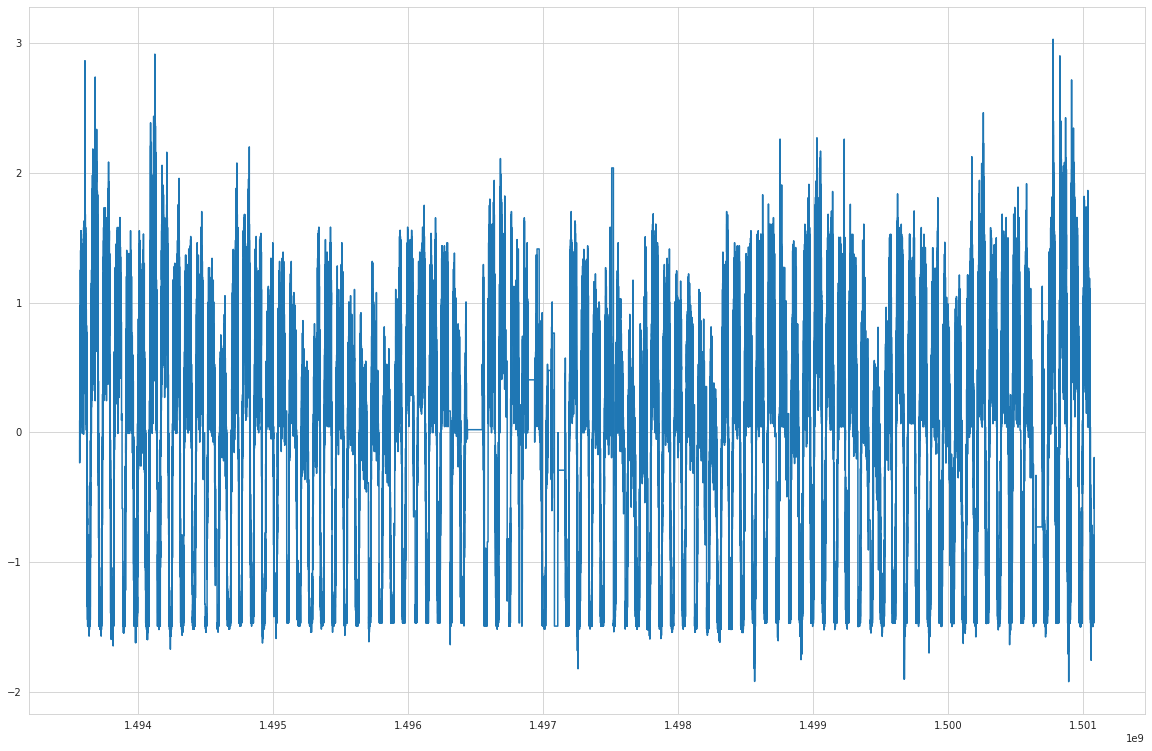

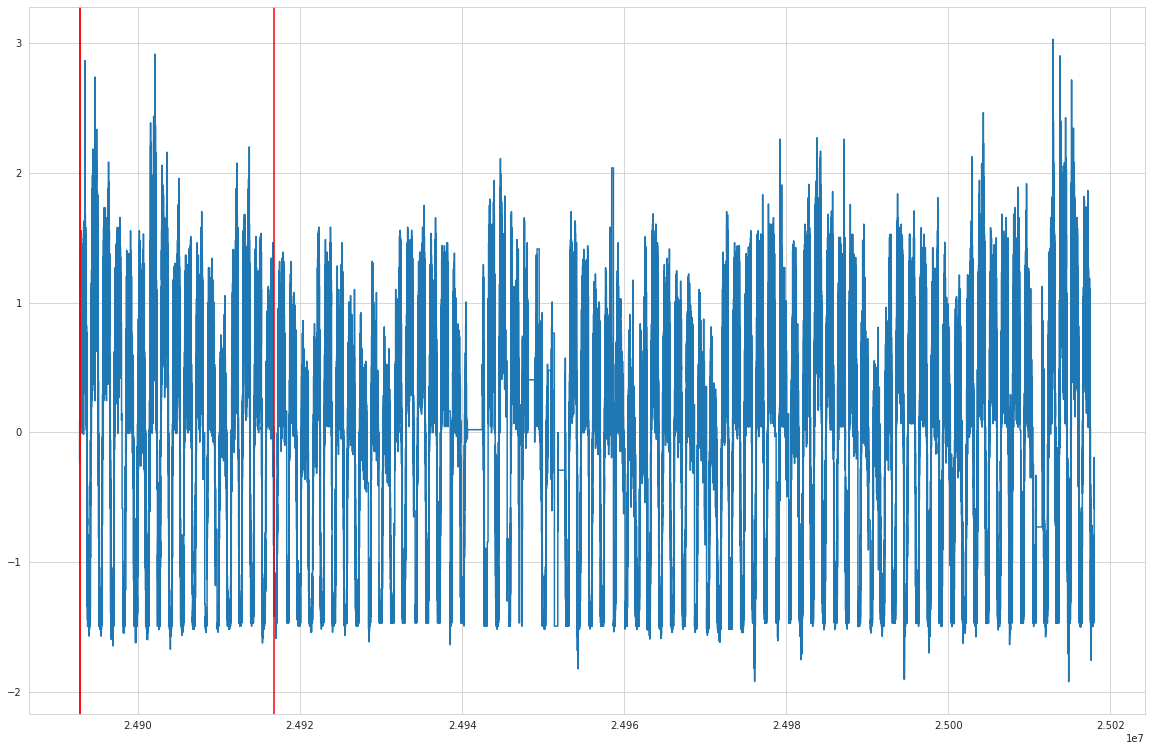

In [34]:
df = dl.train[(dl.train.kpi_id == kpi_id_ref)]

plt.plot(df.timestamp, df.value_scaled, figure=plt.figure(figsize=(20, 13)))
figure = plt.figure(figsize=(20, 13))
plt.plot(df.timestamp, df.value_scaled, figure=figure)
plt.scatter(df[(df.label == 1)].timestamp, df[(df.label == 1)].value_scaled, color='r', figure=figure)

df_ = normal_train[normal_train.kpi_id == kpi_id_ref]
plt.plot(df_.timestamp, df_.value_scaled, figure=plt.figure(figsize=(20, 13)))

df_ = normal_train[normal_train.kpi_id == kpi_id_ref]
figure = plt.figure(figsize=(20, 13))
plt.plot(df_.timestamp_1, df_.value_scaled, figure=figure)
plt.axvline(df_.timestamp_1.min(), figure=figure, c='r')
plt.axvline(df_.timestamp_1.min() + 40, figure=figure, c='r')
plt.axvline(df_.timestamp_1.min() + 24000, figure=figure, c='r')

In [35]:
def predict(model, dataset):
    predictions, losses = [], []
    criterion = nn.L1Loss(reduction='sum').to(device)
    with torch.no_grad():
        model = model.eval()
        for seq_true in dataset:
            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)
            loss = criterion(seq_pred, seq_true)
            predictions.append(seq_pred.cpu().numpy().flatten())
            losses.append(loss.item())
    return predictions, losses

In [36]:
dl.train['timestamp_1'] = (dl.train.timestamp / 60).astype(int)

## Predict abnormal value

In [37]:
train = dl.train.loc[(dl.train.kpi_id == kpi_id_ref)].copy()
train['timestamp_1'] = (train.timestamp / 60).astype(int)


In [38]:
from pytorch_forecasting import TimeSeriesDataSet, GroupNormalizer

train = train.reset_index(drop=True)

training = TimeSeriesDataSet(train.loc[:, X_cols],
                             time_idx='timestamp_1', target='value_scaled',
                             group_ids=['kpi_id'],
                             allow_missing_timesteps=False,
                             static_categoricals=['kpi_id'],
                             time_varying_unknown_reals=['value_scaled'],
                             # time_varying_known_reals=['timestamp_1'],
                             # min_encoder_length=345,
                             max_encoder_length=max_encoder_length,
                             max_prediction_length=max_prediction_length,
                             scalers={col: None for col in ['timestamp_1', 'kpi_id']},
                             target_normalizer=None,
                             # target_normalizer=GroupNormalizer(
                             #     groups=['kpi_id'], transformation="softplus"
                             # ),
                             add_relative_time_idx=False,
                             add_target_scales=False,
                             add_encoder_length=False,
                             )


In [77]:
batch_size = 64

training_dl = training.to_dataloader(train=False, batch_size=batch_size, shuffle=False)


In [78]:
model.eval()

train['prediction'] = np.nan

pred_len = max_encoder_length + max_prediction_length

for i, (X, (y, _)) in tqdm(enumerate(training_dl)):
    seq_true = torch.concat([
        next(iter(training_dl))[0]['encoder_cont'].squeeze(2).moveaxis(1, 0),
        next(iter(training_dl))[0]['decoder_target'].moveaxis(1, 0)
    ]).moveaxis(1, 0).to(torch.float).to(device)
    seq_pred = model(seq_true).detach().cpu().numpy()[0]
    print(seq_pred.shape, seq_pred)
    train['prediction'].iloc[i * pred_len:(i + 1) * pred_len] = pd.Series(seq_pred)
    break



0it [00:00, ?it/s]/tmp/ipykernel_231614/1378681385.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['prediction'].iloc[i*pred_len:(i+1)*pred_len] = pd.Series(seq_pred)
0it [00:00, ?it/s]

(24000,) [ 0.606158    0.68715614  0.66379076 ... -0.63230455 -0.65127337
  0.01011005]


In [79]:
max_ = train[train.prediction.notna()].timestamp_1.max()

In [80]:
train.columns

Index(['index', 'datetime', 'timestamp', 'value', 'label', 'kpi_id', 'missing',
       'value_scaled', 'index_02e99bd4f6cfb33f', 'index_046ec29ddf80d62e',
       'index_07927a9a18fa19ae', 'index_09513ae3e75778a3',
       'index_18fbb1d5a5dc099d', 'index_1c35dbf57f55f5e4',
       'index_40e25005ff8992bd', 'index_54e8a140f6237526',
       'index_71595dd7171f4540', 'index_769894baefea4e9e',
       'index_76f4550c43334374', 'index_7c189dd36f048a6c',
       'index_88cf3a776ba00e7c', 'index_8a20c229e9860d0c',
       'index_8bef9af9a922e0b3', 'index_8c892e5525f3e491',
       'index_9bd90500bfd11edb', 'index_9ee5879409dccef9',
       'index_a40b1df87e3f1c87', 'index_a5bf5d65261d859a',
       'index_affb01ca2b4f0b45', 'index_b3b2e6d1a791d63a',
       'index_c58bfcbacb2822d1', 'index_cff6d3c01e6a6bfa',
       'index_da403e4e3f87c9e0', 'index_e0770391decc44ce', 'timestamp_1',
       'prediction'],
      dtype='object')

In [82]:
(train.label == 0).sum()

114853

In [92]:
np.abs(df.prediction - df.value_scaled).quantile(.95)

0.6845400405613581

/tmp/ipykernel_231614/3456824001.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label_pred'] = np.abs(df.prediction - df.value_scaled) > np.abs(df.prediction - df.value_scaled).quantile(.995)


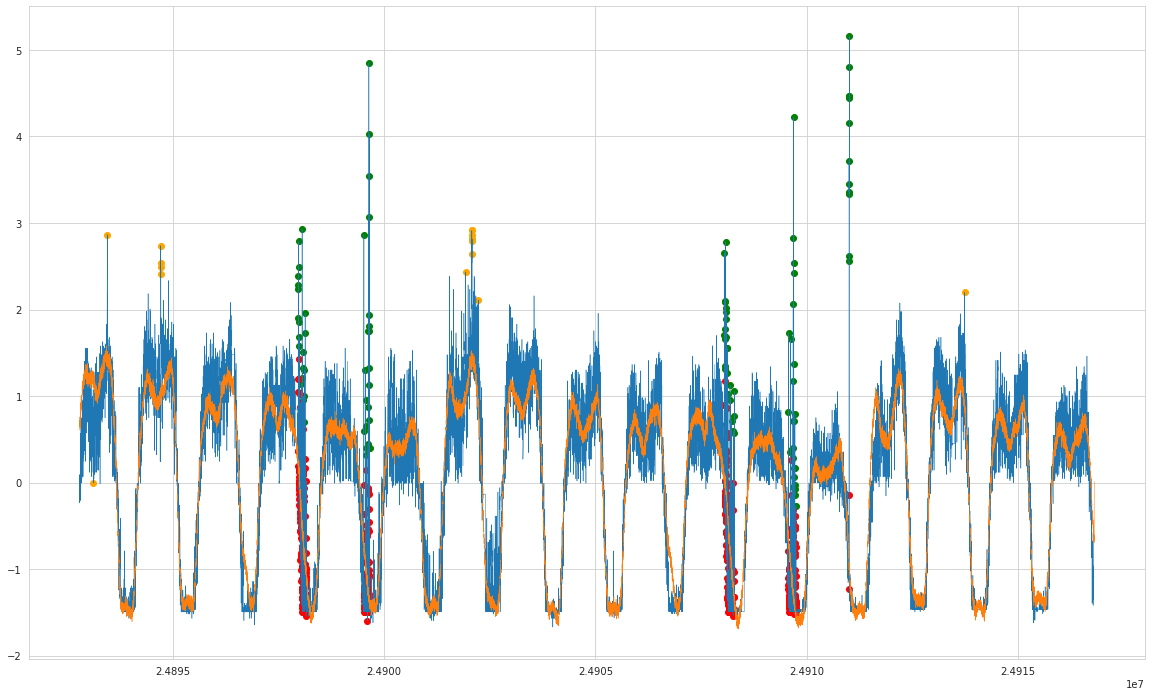

In [100]:
df = train[(train.timestamp_1 <= max_)]
figure = plt.figure(figsize=(20, 12))

THRESHOLD = np.abs(df.prediction - df.value_scaled).quantile(.995)
df['label_pred'] = np.abs(df.prediction - df.value_scaled) > THRESHOLD

true_positive = ((df.label == 1) & (df.label_pred == 1))
false_positive = ((df.label == 0) & (df.label_pred == 1))
false_negative = ((df.label == 1) & (df.label_pred == 0))

for filter, color in zip([true_positive, false_positive, false_negative], ['g', 'orange', 'r']):
    plt.scatter(df[filter].timestamp_1, df[filter].value_scaled, c=color)

plt.plot(df.timestamp_1, df.value_scaled, figure=figure, linewidth=.5)
plt.plot(df.timestamp_1, df.prediction, figure=figure, linewidth=.5)
plt.show()

In [ ]:
pred = model.forward(dl.train)[:, 1]


In [ ]:
THRESHOLD = 1